In [1]:
!pip install -U peft --quiet

In [1]:
!pip install git+https://github.com/huggingface/diffusers
!pip install accelerate wand
!pip install -r https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/requirements.txt

!accelerate config default
# accelerate configuration saved at $HOME/.cache/huggingface/accelerate/default_config.yaml

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-jg4bpvp_
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-jg4bpvp_
  Resolved https://github.com/huggingface/diffusers to commit 92fe689f06bcec27c4f48cb90574c2b9c42c643b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.34.0.dev0-py3-none-any.whl size=3659265 sha256=183d2191c0749b218e068714b1615a04f20b6576ac17bc1c8e116f314473ade3
  Stored in directory: /tmp/pip-ephem-wheel-cache-83ix3s5i/wheels/90/fb/48/a310c271ab42899362ff272062ced42133e5c4c9d0ce77df68
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.33.1
    Uninstalling diffusers-0.33.1:
      Successfully uninstalled diffusers-0.33.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 4.7 MB/s et

In [4]:
import wandb
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, AutoPipelineForText2Image
from huggingface_hub import model_info

In [5]:
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora.py

In [11]:
!mkdir -p ./finetune_lora/truck_art

!accelerate launch --mixed_precision="bf16" train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --dataset_name="ibrahim7004/lora-pak-truck-art" \
  --dataloader_num_workers=8 \
  --resolution=512 \
  --center_crop \
  --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=100 \
  --learning_rate=1e-04 \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" \
  --lr_warmup_steps=0 \
  --output_dir="./finetune_lora/pak_truck_art" \
  --checkpointing_steps=5 \
  --caption_column="caption" \
  --validation_prompt="A colorful Pakistani truck with traditional truck art" \
  --seed=1337

2025-05-10 11:32:28.052671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746876748.072306    9990 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746876748.078293    9990 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
05/10/2025 11:32:33 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: bf16

{'rescale_betas_zero_snr', 'thresholding', 'prediction_type', 'variance_type', 'clip_sample_range', 'dynamic_thresholding_ratio', 'sample_max_value', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
{'shift_facto

In [2]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
from PIL import Image

# Base model
base_model = "runwayml/stable-diffusion-v1-5"

# Load pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model,
    torch_dtype=torch.float16
)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Load LoRA weights
pipe.unet.load_attn_procs("./finetune_lora/pak_truck_art/pytorch_lora_weights.safetensors")
pipe.to("cuda")

# Generate image
prompt = "A modern Pakistani truck with vibrant orange floral art and tiger design"
image = pipe(prompt, num_inference_steps=30).images[0]

# Display and save
image.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/loaders/unet.py:212: FutureWarning: `load_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `load_attn_procs()` method has been deprecated and will be removed in a future version. Please use `load_lora_adapter()`.
  deprecate("load_attn_procs", "0.40.0", deprecation_message)


  0%|          | 0/30 [00:00<?, ?it/s]

In [36]:
# Generate image
prompt = "truck"
image = pipe(prompt, num_inference_steps=30).images[0]

# Display and save
image.show()

  0%|          | 0/30 [00:00<?, ?it/s]

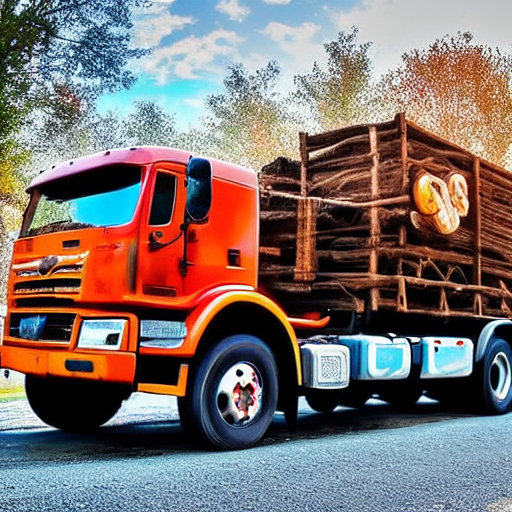

In [37]:
from IPython.display import display
display(image)

In [ ]:
from huggingface_hub import login

login(token="")

In [ ]:
from huggingface_hub import HfApi, HfFolder, upload_folder

api = HfApi()
api.create_repo(repo_id="ibrahim7004/pak-truck-lora", repo_type="model")
upload_folder(repo_id="ibrahim7004/pak-truck-lora", folder_path="./finetune_lora/pak_truck_art", repo_type="model")

---